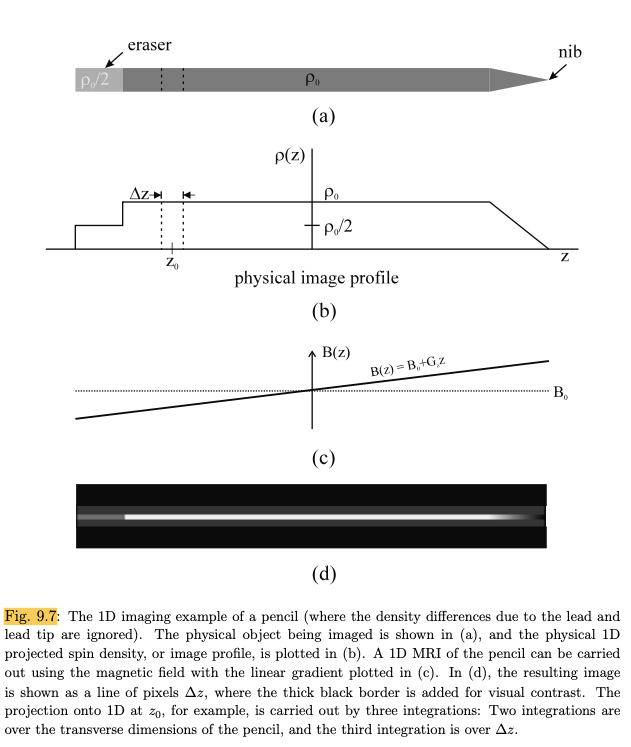

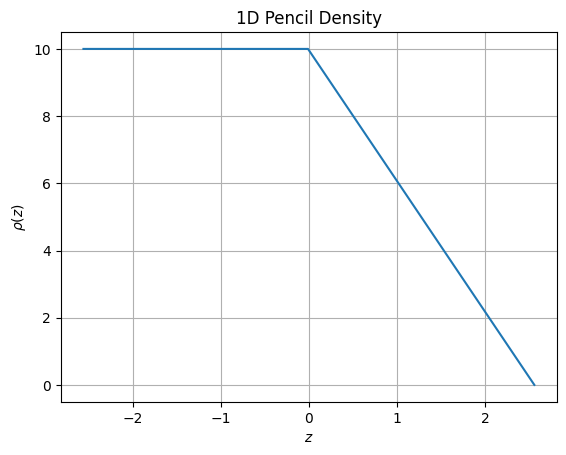

In [1]:
from utilities import *
import matplotlib.pyplot as plt

# Object settings

z = 2.56 # mm 
delta_z = 0.02 # 256 points

rho_0 = 10
pencil_density_profile = density_pencil(z=z, delta_z=delta_z, rho_0=rho_0, plot=True)
# pencil_density_profile = np.ones_like(pencil_density_profile)

# properties settings
T1  = 15*2 # ms. magnetization relaxation time in longitudinal direction
T2  = 10.24 # ms. magnetization relaxation time in transverse direction
# T2s = 0 # ms T2 star
# TE = 1e-2 # ms
TS = 5.12 # ms

B_0 = 0
G_x = 4.6e-3
gamma_bar = 400
gamma = gamma_bar * 2 * np.pi
w0 = B_0 * gamma_bar

# environment settings

# Time
# 0 -- t1 -- t2 -- t3 -- t4
# t1 = 6e-3 # ms set to be 0
# t2 = t1 + TS / 2 # ms
delta_t = 1e-2 # ms
num_of_time = int(TS / delta_t) # between t3 and t4

# ADC sampling setting
delta_k = 1 / 5.12 # /mm^-1
# delta_k = gamma_bar * G_x * delta_t * 1 # 1/delta_k bigger than 5.12
# delta_k = 0.1 # mm^-1, 1/delta_x bigger than 5.12 
FOV = 1 / delta_k # mm

# gradient pulse sequence
# z is just consistent with the physical image profile, not z-axis
pos_z = np.linspace(-z, z-delta_z, int((z / delta_z) * 2))
num_of_points = len(pos_z) # also the number of spins, number of samples on k and x space

# get the m0 depend on the density profile
m0 = 1.0

# create spins after the rf pulse (lying on the y-axis)
vec_spins = np.zeros((3, num_of_points))
vec_spins[1, :] = 1

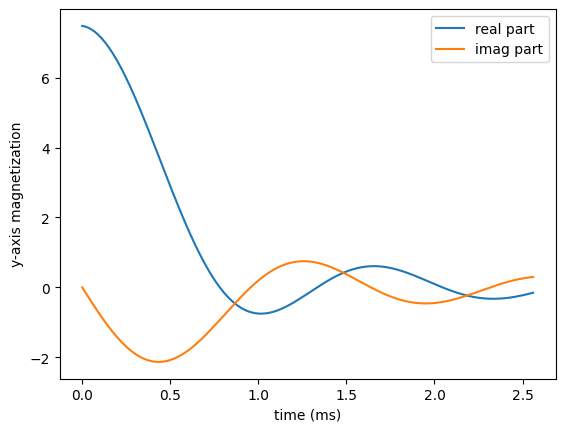

In [2]:
# G_x on between t1 and t2 (T_s / 2)
w_G = w_grad(w_0=w0, G_value=G_x, gamma=gamma_bar, pos=pos_z, dim=1)
res_1 = multiple_FID(vec_spins, m0, w0, w_G, T1, T2, TS / 2, int(num_of_time / 2), 'z')

store = []
for i in range(2):
    tmp = res_1[i,:,:].squeeze()
    store.append(tmp @ pencil_density_profile / pencil_density_profile.shape[0])

real_part_1, imag_part_1 = store[1], store[0] 

# res_mean = np.mean(res_1, axis=-1)
time1 = res_1.shape[1]
# plt.plot(np.linspace(0, time1*delta_t, time1), res_mean[1,:])
plt.plot(np.linspace(0, time1*delta_t, time1), real_part_1, label='real part')
plt.plot(np.linspace(0, time1*delta_t, time1), imag_part_1, label='imag part')
plt.xlabel('time (ms)')
plt.ylabel('y-axis magnetization')
plt.legend()


Text(0, 0.5, 'y-axis magnetization')

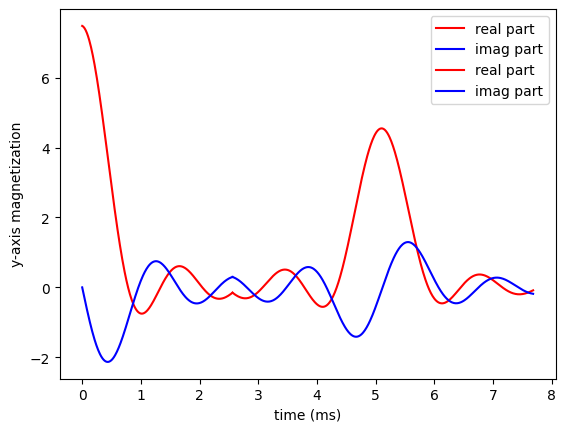

In [3]:
# -G_x on between t2 and t3 (T_s)
w_G = w_grad(w_0=w0, G_value=-G_x, gamma=gamma_bar, pos=pos_z, dim=1)
res_2 = multiple_FID(res_1[:,-1,:], m0, w0, w_G, T1, T2, TS, num_of_time, 'z')

store = []
for i in range(2):
    tmp = res_2[i,:,:].squeeze()
    store.append(tmp @ pencil_density_profile / pencil_density_profile.shape[0])

real_part_2, imag_part_2 = store[1], store[0]

# res shape is (3, num_of_steps, num_of_spins)
# for each steps, return the mean of all spins in 3 directions
# res_mean = np.mean(res_2, axis=-1) # shape = (3, num_of_steps)
time2 = res_2.shape[1]

plt.plot(np.linspace(0, time1*delta_t, time1), real_part_1, 'r-', label='real part')
plt.plot(np.linspace(0, time1*delta_t, time1), imag_part_1, 'b-', label='imag part')

# real part (x-direction)
# plt.plot(delta_t * time1 + np.linspace(0, time2*delta_t, time2), res_mean[0,:])
plt.plot(delta_t * time1 + np.linspace(0, time2*delta_t, time2), real_part_2, 'r-', label='real part')

# imag part (y-direction)
# plt.plot(delta_t * time1 + np.linspace(0, time2*delta_t, time2), res_mean[1,:])
plt.plot(delta_t * time1 + np.linspace(0, time2*delta_t, time2), imag_part_2, 'b-', label='imag part')

plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('y-axis magnetization')

Text(0, 0.5, 'signal')

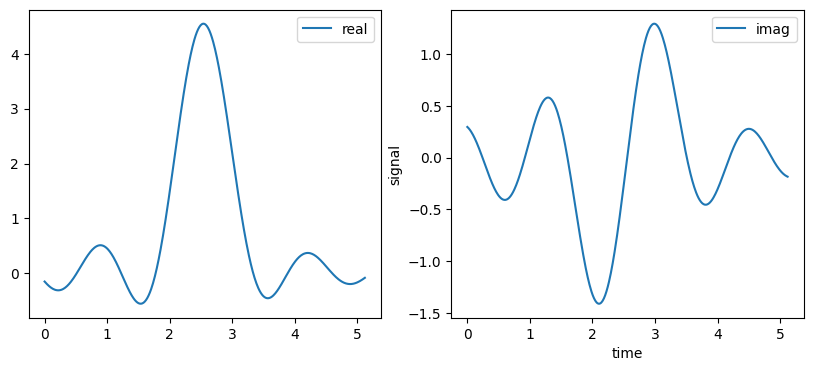

In [4]:
#extract s(t) during ADC process
# s_t = res_mean[1,:]  #.....

# tmp = np.complex(real_part, imag_part)

signal = real_part_2 + 1j * imag_part_2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(np.linspace(0, time2*delta_t, time2), np.real(signal), label='real')
ax2.plot(np.linspace(0, time2*delta_t, time2), np.imag(signal), label='imag')
ax1.legend()
ax2.legend()
plt.xlabel('time')
plt.ylabel('signal')

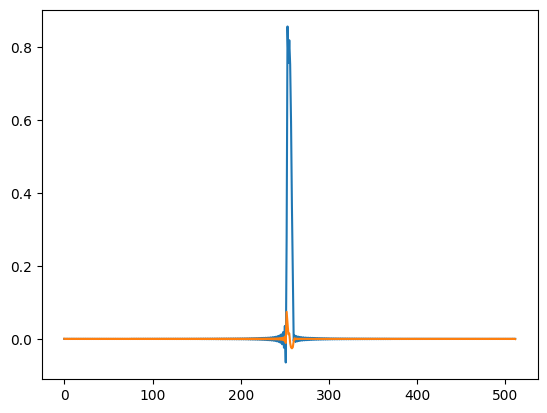

In [16]:
rho_m = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(signal)))
plt.plot(np.real(rho_m))
plt.plot(np.imag(rho_m))

## FT of the density profile

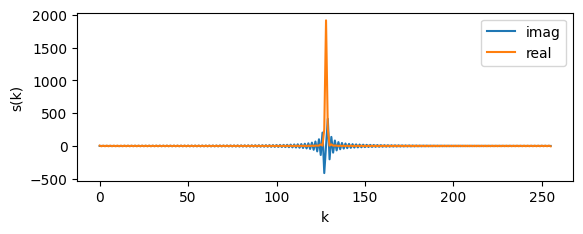

In [18]:
rho = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pencil_density_profile)))
plt.subplot(2, 1, 1)
plt.plot(np.imag(rho), label='imag')
plt.plot(np.real(rho), label='real')
plt.ylabel('s(k)')
plt.xlabel('k')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'k')

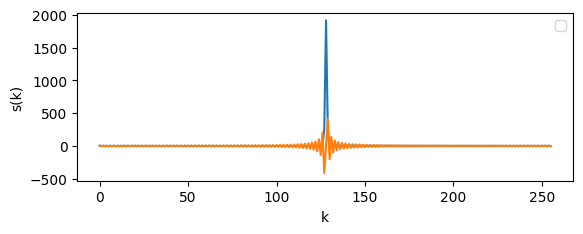

In [19]:
rho = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pencil_density_profile)))
plt.subplot(2, 1, 1)
plt.plot(np.real(rho))
plt.plot(np.imag(rho))
plt.legend()
plt.ylabel('s(k)')
plt.xlabel('k')

Text(0, 0.5, 'rho')

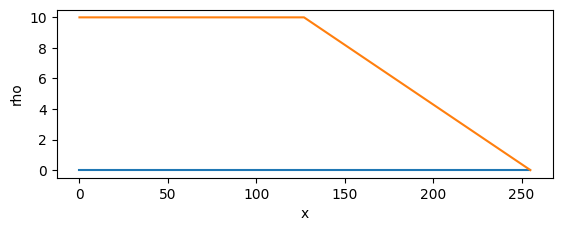

In [22]:
rho_m_x = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(rho)))
plt.subplot(2, 1, 1)
plt.plot(np.imag(rho_m_x))
plt.plot(np.real(rho_m_x))
plt.xlabel('x')
plt.ylabel('rho')